# glider flight model

In [53]:
import xarray as xr
import numpy as np
import gliderflight
import matplotlib.pyplot as plt


In [54]:
# load timeseries data


ds=xr.open_dataset('./L0-timeseries/wam_sbus_461_nov_dec_jan.nc')

(20.0, 0.0)

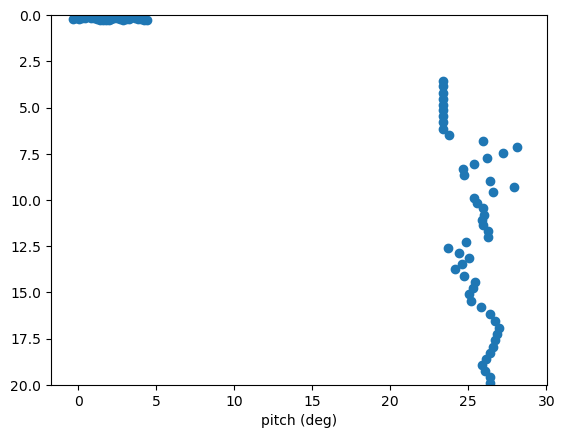

In [80]:
f,ax=plt.subplots()

ax.scatter(np.rad2deg(ds['pitch'])[ds['profile_index']==1001],ds['pressure'][ds['profile_index']==1001])
ax.invert_yaxis()
ax.set_xlabel('pitch (deg)')
ax.set_ylim(20,0)


In [ ]:
f,ax=plt.subplots()

ax.scatter(np.rad2deg(ds['pitch'])[ds['profile_index']==1001],ds['pressure'][ds['profile_index']==1001])
ax.invert_yaxis()
ax.set_xlabel('pitch (deg)')
ax.set_ylim(20,0)


In [65]:
ds

<xarray.Dataset> Size: 863MB
Dimensions:                (time: 3721165)
Coordinates:
  * time                   (time) datetime64[ns] 30MB 2025-11-19T12:31:44 ......
    latitude               (time) float64 30MB -3.219e+03 ... -3.223e+03
    longitude              (time) float64 30MB 1.813e+03 1.813e+03 ... 1.801e+03
    depth                  (time) float64 30MB 0.2087 0.2087 ... 0.2237 0.1889
Data variables: (12/25)
    time_ctd               (time) datetime64[ns] 30MB NaT ... 2026-01-19T14:3...
    heading                (time) float64 30MB ...
    pitch                  (time) float64 30MB 0.3334 0.3334 ... 0.5358 0.5358
    roll                   (time) float64 30MB 0.02094 0.02094 ... -0.04014
    fin                    (time) float64 30MB ...
    thruster_power         (time) float64 30MB ...
    ...                     ...
    salinity               (time) float64 30MB ...
    potential_density      (time) float64 30MB ...
    density                (time) float64 30MB ...
    potential_temperature  (time) float64 30MB ...
    profile_index          (time) float64 30MB ...
    profile_direction      (time) float64 30MB ...
Attributes: (12/61)
    Conventions:               CF-1.8
    Metadata_Conventions:      CF-1.8, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Schmitt Sciences, OBVI, West Afri...
    cdm_data_type:             Trajectory
    comment:                   Southern Benguela Upwelling System glider depl...
    contributor_name:          Sarah Nicholson, Isabelle Giddy, Estel Font, N...
    ...                        ...
    summary:                   First leg of the Southern Benguela Upwelling S...
    time_coverage_end:         2026-01-19T14:35:24.000000000
    time_coverage_start:       2025-11-19T12:31:44.000000000
    title:                     socco-461461-20251119T1231
    transmission_system:       IRRIDIUM
    wmo_id:                    999999

In [56]:
# do this conversion before running the model

import gsw
# 1) Build pressure in dbar from depth (m)
p = gsw.p_from_z(-ds.depth, ds.latitude/100)   # depth positive down

# 2) Convert conductivity to mS/cm if it's in S/m
C_mScm = ds.conductivity * 10.0


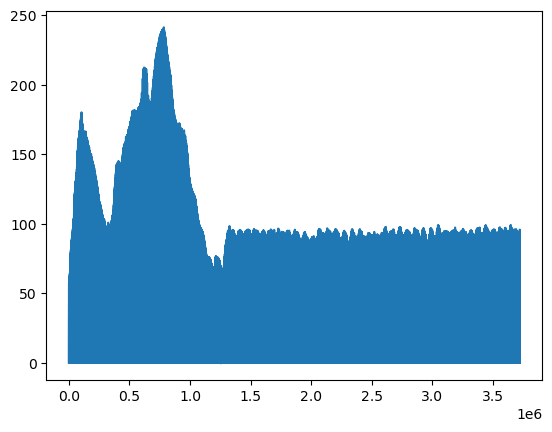

In [57]:
plt.plot(p)

In [58]:
# mask where everything needed is finite
m = np.isfinite(C_mScm) & np.isfinite(ds.temperature) & np.isfinite(p) & np.isfinite(ds.longitude/100) & np.isfinite(ds.latitude/100)

SP = np.full_like(ds.temperature, np.nan, dtype=float)
SA = np.full_like(ds.temperature, np.nan, dtype=float)
rho = np.full_like(ds.temperature, np.nan, dtype=float)

SP[m]  = gsw.SP_from_C(C_mScm[m], ds.temperature[m], p[m])
SA[m]  = gsw.SA_from_SP(SP[m], p[m], (ds.longitude/100)[m], (ds.latitude/100)[m])
rho[m] = gsw.rho_t_exact(SA[m], ds.temperature[m], p[m])


In [60]:
data = dict(time = ds.time_ctd.values[m], pressure=p[m].values/10, pitch = ds.pitch.values[m],
             buoyancy_change=ds.oil_volume.values[m], density=rho[m],roll=ds['roll'].values[m])

# put pressure in bars 

In [ ]:
# convert time to seconds since start, with NaT becoming nan

t = np.asarray(data["time"]).astype("datetime64[ns]")

# find first valid timestamp (not NaT)
good = ~np.isnat(t)
if not np.any(good):
    raise ValueError("All time values are NaT")

t0 = t[good][0]

t_sec = (t - t0) / np.timedelta64(1, "s")
t_sec = t_sec.astype(float)          # NaT becomes nan here 

# clean dict for gliderflight:
m = np.isfinite(t_sec)
data2 = dict(data)
data2["time"] = t_sec[m]
for k in ["pressure", "pitch", "buoyancy_change", "density"]:
    data2[k] = np.asarray(data2[k], dtype=float)[m]


In [14]:

gm = gliderflight.SteadyStateCalibrate(rho0=1024)
gm.set_input_data(**data2)

In [15]:
condition = np.logical_or((data2["pressure"]*10)<20, (data2["pressure"]*10)>80) #reasonable? 
gm.OR(condition)

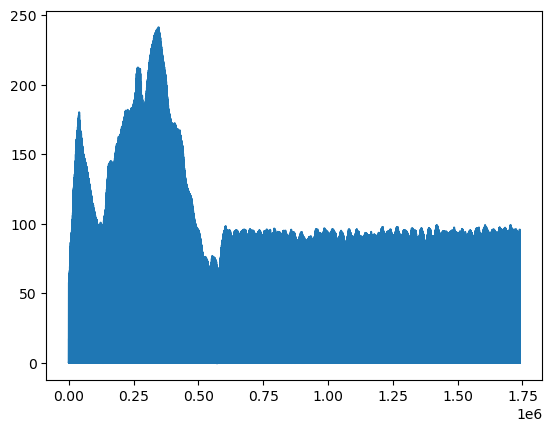

In [16]:
plt.plot(data2["pressure"]*10)

In [17]:
mg=56.73+5.6
Vg=56.73+5.6

gm.define(mg=mg, Vg=Vg, Cd0=0.16) # MR=5.6, Slocum=56.73 Cd0 is first guess, from example tutorial
if not gm.undefined_parameters():
    print("We still have undefined parameters...")
    print(gm.undefined_parameters()) # no undefined parameters

We still have undefined parameters...
[]


In [18]:
calibration_result = gm.calibrate("Vg", "Cd0",verbose=True)


Error: 4.0469408e+03  -  Vg=62.33  Cd0=0.16
Error: 4.2498769e+03  -  Vg=65.45  Cd0=0.16
Error: 3.8793453e+03  -  Vg=62.33  Cd0=0.168
Error: 3.6848150e+03  -  Vg=59.21  Cd0=0.168
Error: 3.4201838e+03  -  Vg=56.1  Cd0=0.172
Error: 3.2893277e+03  -  Vg=56.1  Cd0=0.18
Error: 2.9661395e+03  -  Vg=52.98  Cd0=0.19
Error: 2.5702514e+03  -  Vg=46.75  Cd0=0.194
Error: 2.0266417e+03  -  Vg=38.96  Cd0=0.207
Error: 1.7390662e+03  -  Vg=35.84  Cd0=0.225
Error: 1.1372276e+03  -  Vg=25.71  Cd0=0.2515
Error: 4.8736483e+02  -  Vg=11.69  Cd0=0.2685
Error: 2.3302878e+02  -  Vg=-8.96  Cd0=0.3077
Error: 5.2461672e+02  -  Vg=-22.21  Cd0=0.3522
Error: 1.2156732e+03  -  Vg=-56.88  Cd0=0.4085
Error: 1.9578810e+02  -  Vg=5.064  Cd0=0.2907
Error: 8.2191097e+02  -  Vg=18.31  Cd0=0.2462
Error: 3.0138217e+02  -  Vg=-12.08  Cd0=0.3257
Error: 3.3543401e+02  -  Vg=8.181  Cd0=0.2727
Error: 1.8026440e+02  -  Vg=-7.012  Cd0=0.3125
Error: 2.6927272e+02  -  Vg=7.012  Cd0=0.2955
Error: 1.3012110e+02  -  Vg=-4.967  Cd0=0.3047

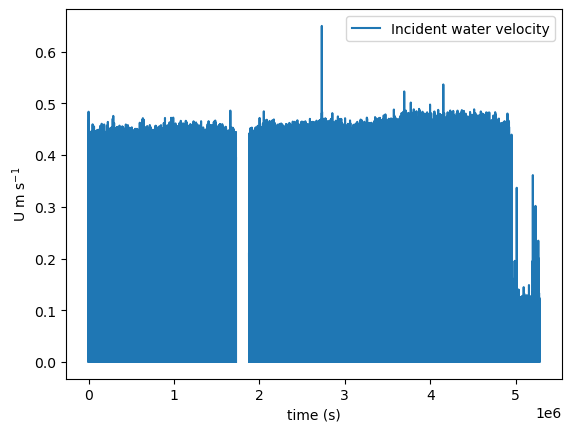

In [17]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,1)

ax.plot(gm.t, gm.U, label='Incident water velocity')
ax.set_xlabel('time (s)')
ax.set_ylabel('U m s$^{-1}$')
ax.legend()

(1739787,)

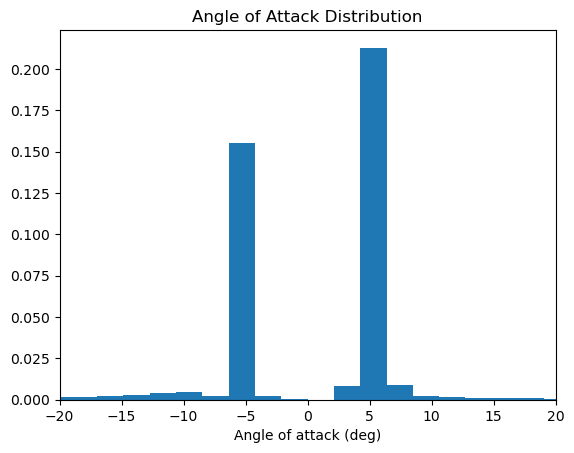

In [21]:
# plot histogram of angle of attack
f, ax = plt.subplots(1,1)
ax.hist(np.rad2deg(gm.alpha), bins=50,density=True)
ax.set_xlabel('Angle of attack (deg)')
# ax.set_ylabel('Counts')
ax.set_title('Angle of Attack Distribution')
ax.set_xlim(-20,20)
plt.show()  

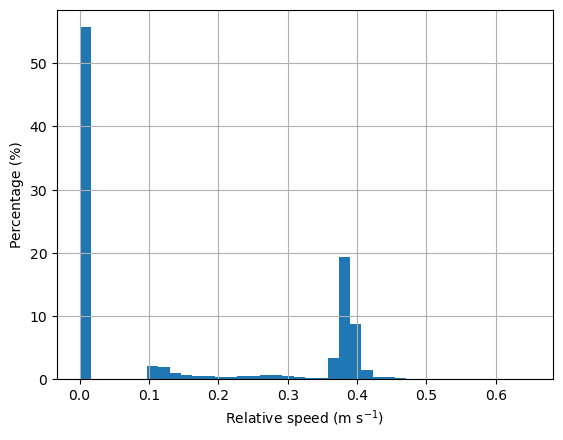

In [ ]:
# plot histogram of velocity through water
import numpy as np
import matplotlib.pyplot as plt

x = gm.U

plt.figure()
counts, bins, patches = plt.hist(x, bins=40, density=True)

# Convert density to percentage
bin_width = np.diff(bins)
percent = counts * bin_width * 100

plt.clf()
plt.bar(bins[:-1], percent, width=bin_width, align='edge')

plt.xlabel("Relative speed (m s$^{-1}$)")
plt.ylabel("Percentage (%)")
# plt.grid(True)

threshold=0.015
plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')

plt.show()


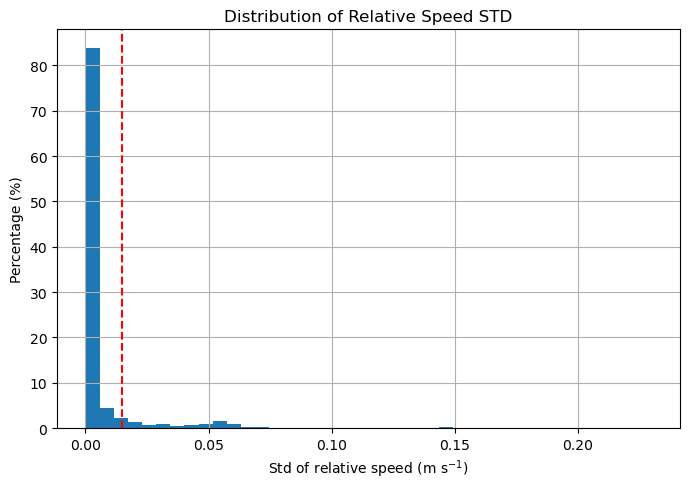

In [28]:
# standard deviation of speed
import pandas as pd
u = pd.Series(gm.U)

window = 10   # samples
u_std = u.rolling(window, center=True).std()

x = u_std.values
x = x[np.isfinite(x)]

counts, bins = np.histogram(x, bins=40)

percent = 100 * counts / counts.sum()

plt.figure(figsize=(7,5))
plt.bar(bins[:-1], percent, width=np.diff(bins), align='edge')

plt.xlabel("Std of relative speed (m s$^{-1}$)")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Relative Speed STD")
plt.grid(True)
plt.tight_layout()
threshold=0.015
plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')

plt.show()



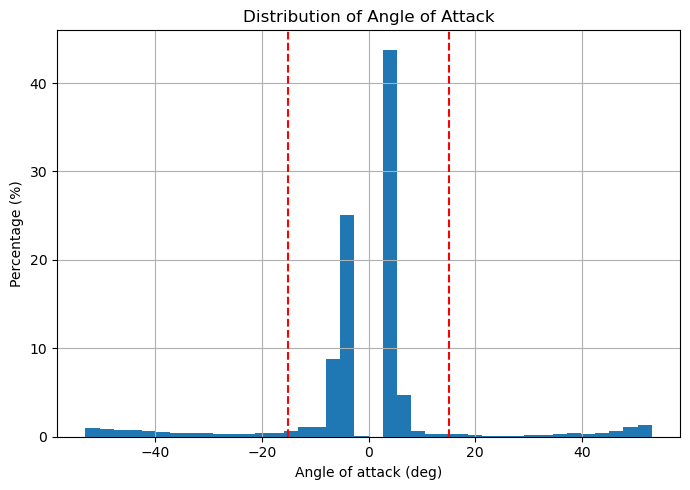

In [30]:
# standard deviation of speed
import pandas as pd

x=np.rad2deg(gm.alpha)

counts, bins = np.histogram(x, bins=40)

percent = 100 * counts / counts.sum()

plt.figure(figsize=(7,5))
plt.bar(bins[:-1], percent, width=np.diff(bins), align='edge')

plt.xlabel("Angle of attack (deg)")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Angle of Attack")
plt.grid(True)
plt.tight_layout()
threshold=15
plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')
plt.axvline(-threshold, color='r', linestyle='--', label='QC threshold')

plt.show()



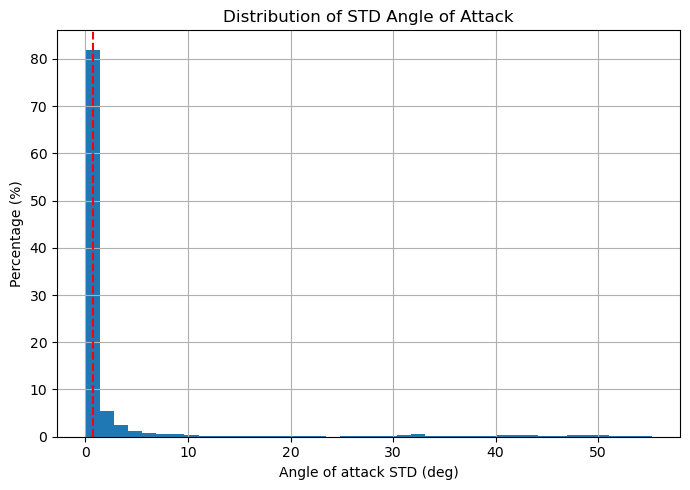

In [ ]:
# standard deviation of aoa
import pandas as pd

x=np.rad2deg(gm.alpha)
aoa = pd.Series(x)

window = 10  # samples
aoa_std = aoa.rolling(window, center=True).std()

x = aoa_std.values
x = x[np.isfinite(x)]


counts, bins = np.histogram(x, bins=40)

percent = 100 * counts / counts.sum()

plt.figure(figsize=(7,5))
plt.bar(bins[:-1], percent, width=np.diff(bins), align='edge')

plt.xlabel("Angle of attack STD (deg)")
plt.ylabel("Percentage (%)")
plt.title("Distribution of STD Angle of Attack")
plt.grid(True)
plt.tight_layout()
threshold=0.75
plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')
# plt.axvline(-threshold, color='r', linestyle='--', label='QC threshold')

plt.show()

# not sure what is going on here???


In [38]:
data2

{'time': array([0.00000000e+00, 4.00402842e+00, 9.99688730e+00, ...,
        5.27767080e+06, 5.27767280e+06, 5.27767480e+06], shape=(1739787,)),
 'pressure': array([0.02101762, 0.02001678, 0.02101762, ..., 0.02903066, 0.02602749,
        0.01902009], shape=(1739787,)),
 'pitch': array([0.1504627 , 0.14187028, 0.12899229, ..., 0.53581607, 0.53581607,
        0.53581607], shape=(1739787,)),
 'buoyancy_change': array([257.52944946, 257.52944946, 257.52944946, ..., 254.41292251,
        254.41294808, 254.41297365], shape=(1739787,)),
 'density': array([1026.06943897, 1026.06638184, 1026.06849336, ..., 1026.19315329,
        1026.19483631, 1026.194806  ], shape=(1739787,))}

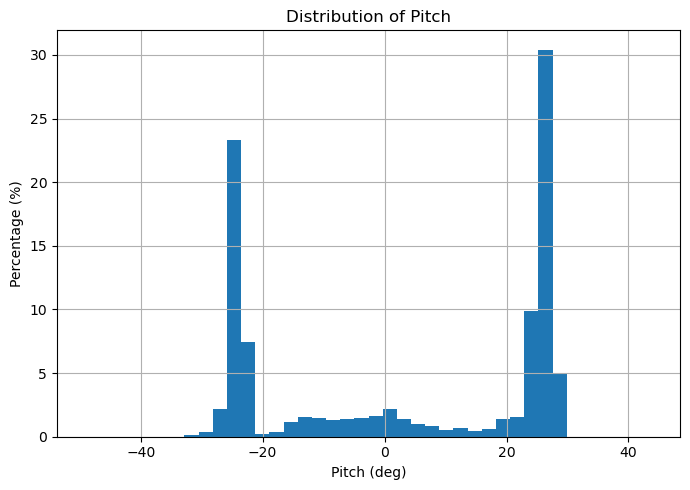

In [ ]:
# distribution of pitch
x=np.rad2deg(data2['pitch'])

counts, bins = np.histogram(x, bins=40)

percent = 100 * counts / counts.sum()

plt.figure(figsize=(7,5))
plt.bar(bins[:-1], percent, width=np.diff(bins), align='edge')

plt.xlabel("Pitch (deg)")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Pitch")
plt.grid(True)
plt.tight_layout()
# threshold=15
# plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')
# plt.axvline(-threshold, color='r', linestyle='--', label='QC threshold')

plt.show()



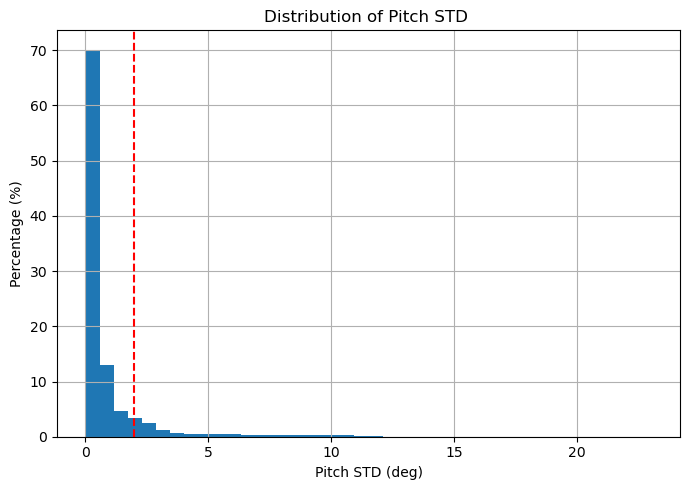

In [42]:
# distribution of standard deviation of pitch
x=np.rad2deg(data2['pitch'])

pitch = pd.Series(x)

window = 10  # samples
pitch_std = pitch.rolling(window, center=True).std()

x = pitch_std.values
x = x[np.isfinite(x)]

counts, bins = np.histogram(x, bins=40)

percent = 100 * counts / counts.sum()

plt.figure(figsize=(7,5))
plt.bar(bins[:-1], percent, width=np.diff(bins), align='edge')

plt.xlabel("Pitch STD (deg)")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Pitch STD ")
plt.grid(True)
plt.tight_layout()
threshold=2
plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')
# plt.axvline(-threshold, color='r', linestyle='--', label='QC threshold')

plt.show()

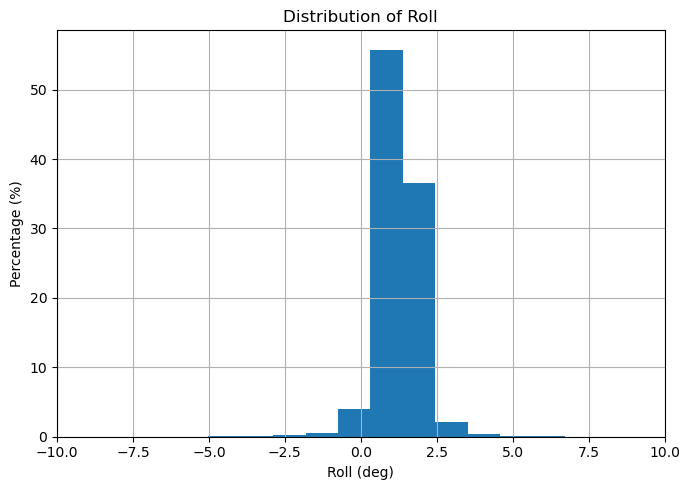

In [63]:
# distribution of roll
x=np.rad2deg(ds['roll'].values)

counts, bins = np.histogram(x, bins=40)

percent = 100 * counts / counts.sum()

plt.figure(figsize=(7,5))
plt.bar(bins[:-1], percent, width=np.diff(bins), align='edge')

plt.xlabel("Roll (deg)")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Roll")
plt.xlim(-10,10)
plt.grid(True)
plt.tight_layout()
# threshold=15
# plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')
# plt.axvline(-threshold, color='r', linestyle='--', label='QC threshold')

plt.show()



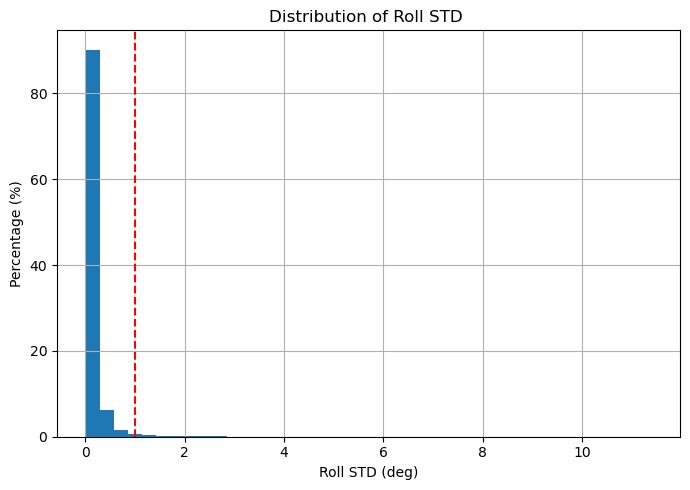

In [64]:
# distribution of standard deviation of roll
x=np.rad2deg(ds['roll'])

roll = pd.Series(x)

window = 10  # samples
roll_std = roll.rolling(window, center=True).std()

x = roll_std.values
x = x[np.isfinite(x)]

counts, bins = np.histogram(x, bins=40)

percent = 100 * counts / counts.sum()

plt.figure(figsize=(7,5))
plt.bar(bins[:-1], percent, width=np.diff(bins), align='edge')

plt.xlabel("Roll STD (deg)")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Roll STD ")
plt.grid(True)
plt.tight_layout()
threshold=1
plt.axvline(threshold, color='r', linestyle='--', label='QC threshold')
# plt.axvline(-threshold, color='r', linestyle='--', label='QC threshold')

plt.show()

## Test Dynamic model

In [173]:
fm = gliderflight.DynamicGliderModel(dt=1, rho0=1024, k1=0.02, k2=0.92)
# copy the settings from the steady state model
fm.copy_settings(gm)
fm.max_CPUs = 1
# solution = fm.solve(data2)


# solution is now a named tuple, according to the definition:
# Modelresult = namedtuple("Modelresult", "t u w U alpha pitch ww")

In [174]:
import numpy as np

t = np.asarray(data2["time"], float)
print("time finite:", np.isfinite(t).mean())
dt = np.diff(t)
print("dt min:", dt.min(), "dt median:", np.median(dt))
print("duplicates:", np.sum(dt == 0), "reversals:", np.sum(dt < 0))

for k in ["pressure","pitch","buoyancy_change","density"]:
    a = np.asarray(data2[k], float)
    print(k, "finite:", np.isfinite(a).mean())


time finite: 1.0
dt min: 0.0 dt median: 2.0
duplicates: 26 reversals: 0
pressure finite: 1.0
pitch finite: 1.0
buoyancy_change finite: 1.0
density finite: 1.0


In [175]:
import numpy as np

def clean_for_dynamic(data):
    t = np.asarray(data["time"], float)

    # build finite mask across required vars
    m = np.isfinite(t)
    for k in ["pressure","pitch","buoyancy_change","density"]:
        m &= np.isfinite(np.asarray(data[k], float))

    t = t[m]
    p = np.asarray(data["pressure"], float)[m]
    pitch = np.asarray(data["pitch"], float)[m]
    bc = np.asarray(data["buoyancy_change"], float)[m]
    rho = np.asarray(data["density"], float)[m]
    # dhdt = np.asarray(data["dhdt"], float)[m]

    # sort by time
    idx = np.argsort(t)
    t, p, pitch, bc, rho = t[idx], p[idx], pitch[idx], bc[idx], rho[idx]

    # drop duplicates and enforce strictly increasing time
    keep = np.diff(t, prepend=t[0]-1) > 0
    return dict(time=t[keep], pressure=p[keep], pitch=pitch[keep],
                buoyancy_change=bc[keep], density=rho[keep])

data2c = clean_for_dynamic(data2)
solution = fm.solve(data2c)


In [176]:
solution

Modelresult(t=array([0.00000000e+00, 2.00000000e+00, 4.00000000e+00, ...,
       1.72336856e+06, 1.72337056e+06, 1.72337656e+06], shape=(671317,)), u=array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -2.71261158e-09,  2.24243103e-08,  2.66006054e-08], shape=(671317,)), w=array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.43922707e-09,  1.18976395e-08,  1.41134513e-08], shape=(671317,)), U=array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.07077126e-09, 2.53851043e-08, 3.01128165e-08], shape=(671317,)), alpha=array([ 0.36096284,  0.37154294,  0.38212304, ..., -2.61015688,
        0.53143577,  0.53143577], shape=(671317,)), pitch=array([-0.36096284, -0.37154294, -0.38212304, ..., -0.04363323,
       -0.04363323, -0.04363323], shape=(671317,)), ww=array([ 0.04981443,  0.01743505, -0.01494433, ...,  0.01245805,
       -0.00125446,  0.00330882], shape=(671317,)), depth=array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,


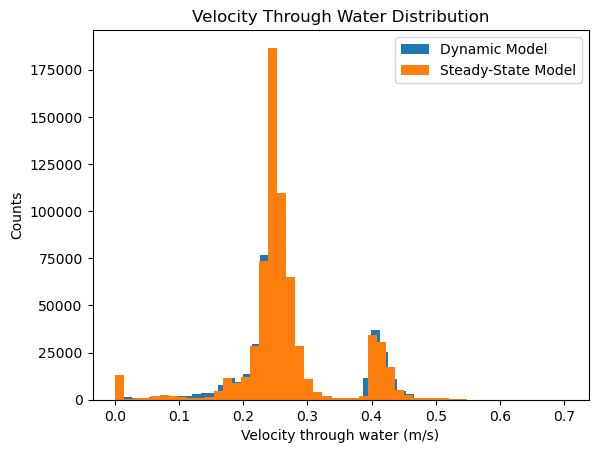

In [186]:
# plot histogram of velocity through water
f, ax = plt.subplots(1,1)
ax.hist(solution.U, bins=50,label='Dynamic Model')
ax.hist(gm.U, bins=50,label='Steady-State Model'        )
ax.legend()
ax.set_xlabel('Velocity through water (m/s)')
ax.set_ylabel('Counts')
ax.set_title('Velocity Through Water Distribution')
plt.show()


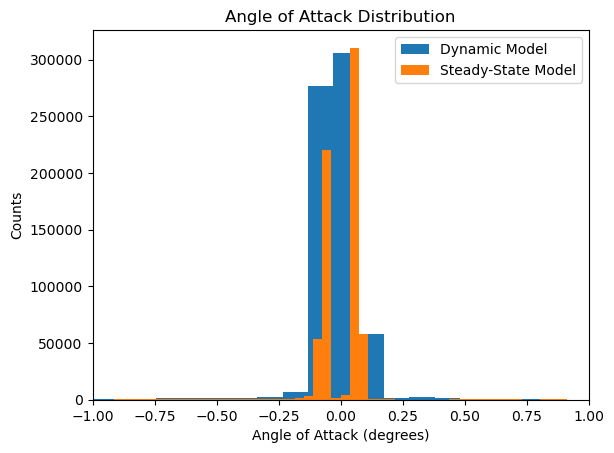

In [185]:
# plot histogram of aoa and add legends for each histogram


f, ax = plt.subplots(1,1)
ax.hist(solution.alpha, bins=50,label='Dynamic Model')
ax.hist(gm.alpha, bins=50,label='Steady-State Model')
ax.set_xlim(-1,1)

ax.legend()
ax.set_xlabel('Angle of Attack (degrees)')
ax.set_ylabel('Counts')
ax.set_title('Angle of Attack Distribution')
plt.show()
